<a href="https://colab.research.google.com/github/elizavetkachenko/portfolio/blob/main/Analysis_by_device_and_channel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [ ]:
! pip install google-cloud-bigquery

In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()

client = bigquery.Client(project="data-analytics-mate")

# SQL query

query = """
WITH session_info AS(
SELECT date AS order_date,
s.ga_session_id,
continent,
country,
device,
browser,
mobile_model_name,
operating_system,
language,
medium AS traffic_source,
channel
FROM `DA.session` AS s
LEFT JOIN `DA.session_params`AS sp
ON s.ga_session_id = sp.ga_session_id),

account_info AS (
  SELECT ga_session_id,
account_id,
CASE
    WHEN is_verified = 1 THEN 'Yes'
    ELSE 'No'
END
  AS is_email_verified,
CASE
    WHEN is_unsubscribed = 1 THEN 'No'
    ELSE 'Yes'
END
  AS is_user_unsubscribed
FROM `DA.account` AS ac
JOIN `DA.account_session` AS acs
ON ac.id = acs.account_id
),

product_info AS(
SELECT ga_session_id,
category,
name AS product_name,
price,
short_description
FROM `DA.product` AS p
JOIN `DA.order` AS o
ON p.item_id = o.item_id
)

SELECT order_date,
s.ga_session_id,
continent,
country,
device,
browser,
mobile_model_name,
operating_system,
language,
traffic_source,
channel,
account_id,
is_email_verified,
is_user_unsubscribed,
category,
product_name,
price,
short_description
FROM session_info AS s
LEFT JOIN account_info AS ac
ON s.ga_session_id = ac.ga_session_id
LEFT JOIN product_info AS p
ON s.ga_session_id = p.ga_session_id
"""

query_job = client.query(query)
results = query_job.result()

In [ ]:
df = results.to_dataframe()
df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,channel,account_id,is_email_verified,is_user_unsubscribed,category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,None,None,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,None,None,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,None,None,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,None,None,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,None,None,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


# Data overview

**Columns:**

order_date — Purchase date or session end

ga_session_id — Unique Google Analytics session ID

continent — User’s continent

country — User’s country

device — Device type: desktop, mobile, tablet

browser — Browser used

mobile_model_name — Mobile device model (if any)

operating_system — Device operating system

language — Browser or device language

traffic_source — Traffic source (e.g., Google, Facebook, Direct)

channel — Channel type: organic, paid, referral, etc.

account_id — User account ID (if registered)

is_email_verified — Whether email is verified

is_user_unsubscribed — Whether user unsubscribed from mailing

category — Product category

product_name — Product name

price — Product price

short_description — Short product description

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_date            349545 non-null  dbdate 
 1   ga_session_id         349545 non-null  Int64  
 2   continent             349545 non-null  object 
 3   country               349545 non-null  object 
 4   device                349545 non-null  object 
 5   browser               349545 non-null  object 
 6   mobile_model_name     349545 non-null  object 
 7   operating_system      349545 non-null  object 
 8   language              235279 non-null  object 
 9   traffic_source        349545 non-null  object 
 10  channel               349545 non-null  object 
 11  account_id            27945 non-null   Int64  
 12  is_email_verified     27945 non-null   object 
 13  is_user_unsubscribed  27945 non-null   object 
 14  category              33538 non-null   object 
 15  

In [ ]:
df['ga_session_id'] = df['ga_session_id'].astype(str)
df['account_id'] = df['account_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
# Total number of columns
total_columns = df.shape[1]

# Numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_numeric = len(numeric_cols)

# Categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_categorical = len(categorical_cols)

# Datetime columns
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
num_datetime = len(datetime_cols)

# Number of unique sessions
unique_sessions = df['ga_session_id'].nunique()

# Time period
date_range = (df['order_date'].min(), df['order_date'].max())

# Results
print(f"Total columns: {total_columns}")
print(f"Numeric columns ({num_numeric}): {numeric_cols}")
print(f"Categorical columns ({num_categorical}): {categorical_cols}")
print(f"Datetime columns ({num_datetime}): {datetime_cols}")
print(f"Unique sessions: {unique_sessions}")
print(f"Date range: from {date_range[0].date()} to {date_range[1].date()}")

Total columns: 18
Numeric columns (1): ['price']
Categorical columns (16): ['ga_session_id', 'continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'channel', 'account_id', 'is_email_verified', 'is_user_unsubscribed', 'category', 'product_name', 'short_description']
Datetime columns (1): ['order_date']
Unique sessions: 349545
Date range: from 2020-11-01 to 2021-01-31


In [ ]:
print("Unique sessions:", df['ga_session_id'].nunique())
print("Unique accounts:", df['account_id'].nunique())

Unique sessions: 349545
Unique accounts: 27946


# Data cleaning

## Missing values

In [ ]:
# Missing values
missing_summary = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_percent
}).sort_values(by='Missing %', ascending=False)

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

Missing values summary:
                      Missing Count  Missing %
is_user_unsubscribed         321600      92.01
is_email_verified            321600      92.01
short_description            316007      90.41
price                        316007      90.41
category                     316007      90.41
product_name                 316007      90.41
language                     114266      32.69


**Reasons for missing values:**

is_user_unsubscribed and is_email_verified (92%) may be missing for most sessions, because most users were not registered. Data about email verification and subscription are available only for registered accounts, which are the minority in the dataset.

product_name, category, price, short_description (90%) are missing because not all sessions ended with an order. Product information is available only for sessions where a purchase was made.

language (33%) may be missing because not all browsers send language data, or it was not read/saved in the session parameters.

In [ ]:
df["language"] = df["language"].fillna("unknown")
df['product_name'] = df['product_name'].fillna('no_purchase')
df['category'] = df['category'].fillna('no_purchase')
df['short_description'] = df['short_description'].fillna('no_description')

Some columns are filled with technically neutral values (for example, "unknown" or "no_purchase") to make analysis and visualization easier. Other columns were left as they are, because the fact of missing values itself has analytical value.

## Duplicates

In [ ]:
def create_translation_table():
    cyrillic = 'аеорсухвкмнтАЕОРСУХВКМНТ'
    latin = 'aeopcyxbkmntAEOPCYXBKMHT'
    return str.maketrans(cyrillic, latin)

translation_table = create_translation_table()

def replace_cyrillic_to_latin(text):
    return str(text).translate(translation_table)

# List of columns to process
columns_to_process = [
    'continent', 'country', 'device', 'browser', 'mobile_model_name',
    'operating_system', 'language', 'traffic_source', 'channel',
    'category', 'product_name', 'short_description'
]

for column in columns_to_process:
    if column in df.columns:
        df[column] = df[column].apply(replace_cyrillic_to_latin).astype(str).str.strip().str.title()

# Check for duplicates
duplicates = df[df.duplicated()]
print(f"Number of duplicates: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates)

Number of duplicates: 0


## Outliers

In [ ]:
df[['price']].describe()

,price
count,33538.000000
mean,953.298679
std,1317.001775
min,3.000000
25%,170.000000
50%,445.000000
75%,1195.000000
max,9585.000000


**Conclusion about anomalies:**

Most products cost up to 1200, but there are some items with very high prices - up to 9585. This is much higher than the average and may show abnormally expensive goods or premium products. Such values should be checked separately - maybe these are real VIP sales, or maybe data errors.

# Data analysis and visualization

## Distribution

In [ ]:
device_counts = df['device'].value_counts(normalize=True).round(4) * 100
print("Distribution by device type (%):")
print(device_counts)

channel_counts = df['channel'].value_counts(normalize=True).round(4) * 100
print("\nDistribution by traffic channels (%):")
print(channel_counts)

Distribution by device type (%):
device
Desktop    58.48
Mobile     39.27
Tablet      2.25
Name: proportion, dtype: float64

Distribution by traffic channels (%):
channel
Organic Search    35.60
Paid Search       26.99
Direct            23.28
Social Search      7.99
Undefined          6.15
Name: proportion, dtype: float64


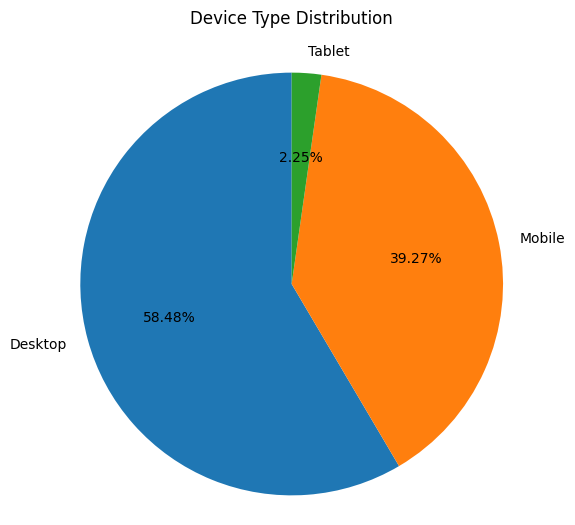

In [ ]:
import matplotlib.pyplot as plt

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(device_counts, labels=device_counts.index, autopct='%1.2f%%', startangle=90)
plt.title("Device Type Distribution\n")
plt.axis('equal')
plt.show()


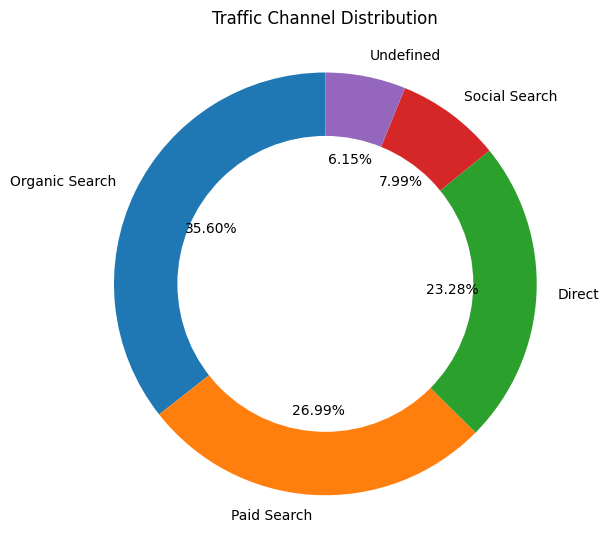

In [ ]:
# Donut chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(channel_counts, labels=channel_counts.index,
                                  autopct='%1.2f%%', startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

ax.set_title("Traffic Channel Distribution\n")
ax.axis('equal')
plt.show()

Most users make purchases from computers (58%), and mobile devices are the second most popular (39%). The main traffic source is organic search (36%), followed by paid ads (27%) and direct visits (23%). This shows the strong role of SEO and a stable mobile presence.

## Sales by device and channel

In [ ]:
#Filter only sessions with purchases
df_sales = df[~df['price'].isna()].copy()

In [ ]:
# Total sales by device types
sales_by_device = df_sales.groupby('device')['price'].sum().sort_values(ascending=False)
sales_by_device

,price
device,
Desktop,18864039.0
Mobile,12384225.8
Tablet,723466.3


In [ ]:
# Total sales by traffic channels
sales_by_channel = df_sales.groupby('channel')['price'].sum().sort_values(ascending=False)
sales_by_channel

,price
channel,
Organic Search,11433151.6
Paid Search,8511049.4
Direct,7494923.4
Social Search,2532105.7
Undefined,2000501.0


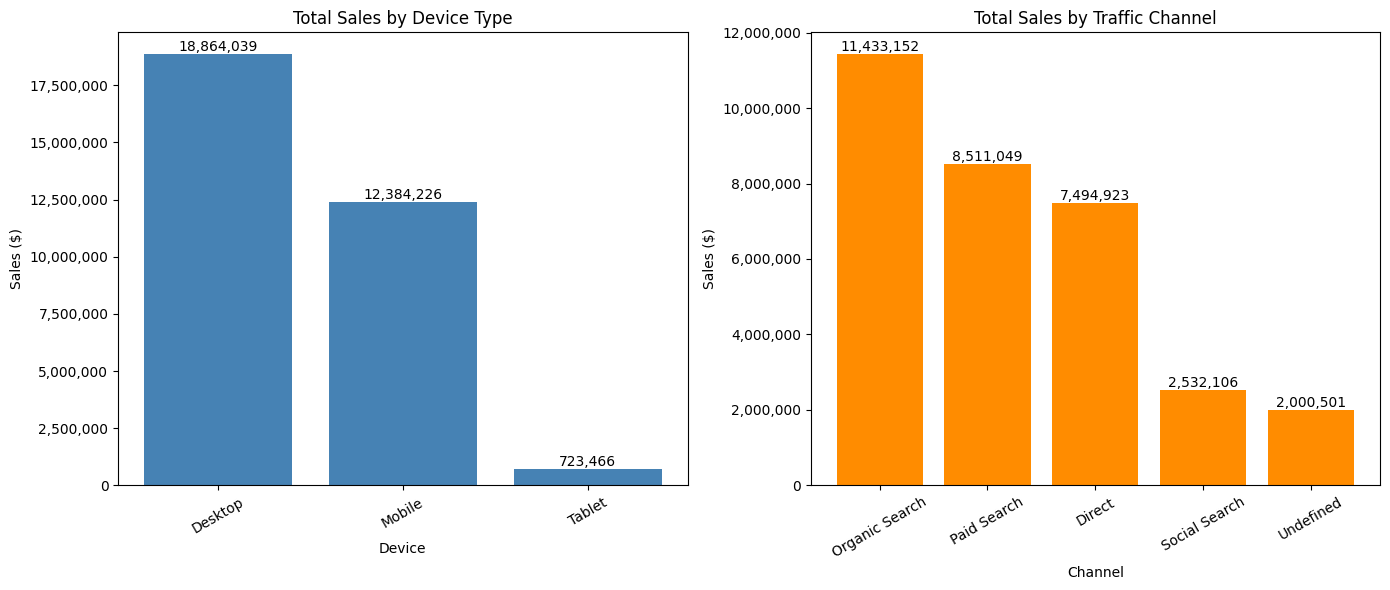

In [ ]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# sales by device types
bars1 = axes[0].bar(sales_by_device.index, sales_by_device.values, color='steelblue')
axes[0].set_title("Total Sales by Device Type")
axes[0].set_xlabel("Device")
axes[0].set_ylabel("Sales ($)")
axes[0].tick_params(axis='x', rotation=30)
axes[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height, f"{height:,.0f}", ha='center', va='bottom')

# sales by traffic channels
bars2 = axes[1].bar(sales_by_channel.index, sales_by_channel.values, color='darkorange')
axes[1].set_title("Total Sales by Traffic Channel")
axes[1].set_xlabel("Channel")
axes[1].set_ylabel("Sales ($)")
axes[1].tick_params(axis='x', rotation=30)
axes[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height, f"{height:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# Pivot table: sales by devices × channels
sales_device_channel = df_sales.pivot_table(
    index='device',
    columns='channel',
    values='price',
    aggfunc='sum',
    fill_value=0)

sales_device_channel

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
device,,,,,
Desktop,4472609.4,6794107.8,4976977.8,1447384.8,1172959.2
Mobile,2875317.9,4408875.1,3330032.6,1006707.3,763292.9
Tablet,146996.1,230168.7,204039.0,78013.6,64248.9


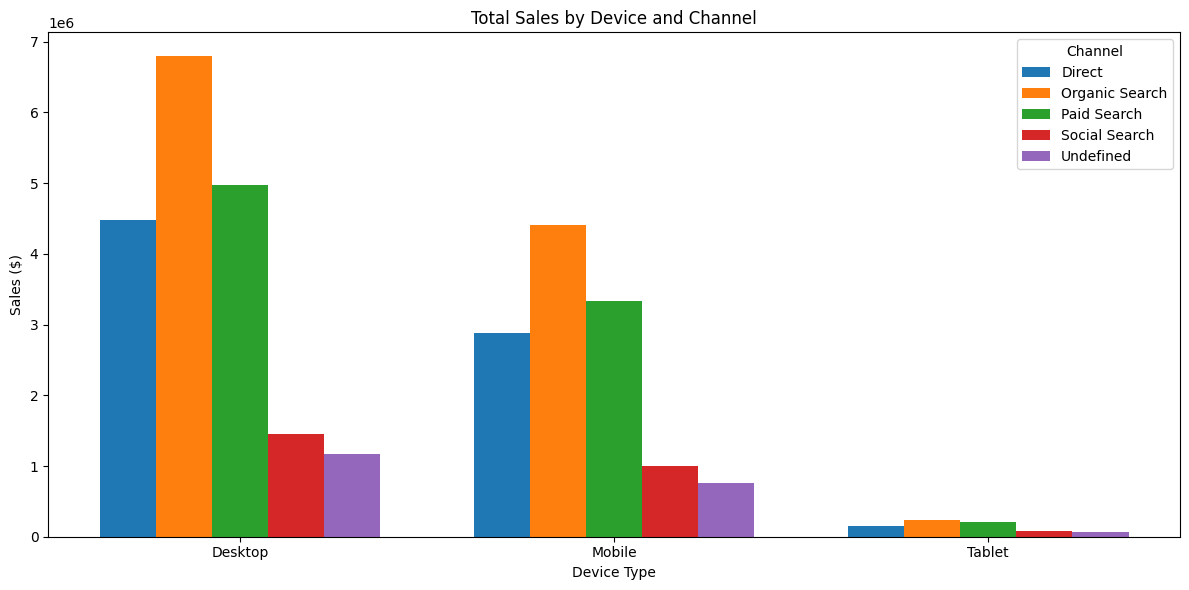

In [ ]:
devices = sales_device_channel.index
channels = sales_device_channel.columns
x = np.arange(len(devices))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))

for i, channel in enumerate(channels):
    ax.bar(x + i*width, sales_device_channel[channel], width, label=channel)

ax.set_title("Total Sales by Device and Channel")
ax.set_xlabel("Device Type")
ax.set_ylabel("Sales ($)")
ax.set_xticks(x + width * (len(channels)-1)/2)
ax.set_xticklabels(devices)
ax.legend(title="Channel")
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# Pivot table: median order value for each combination
avg_check_device_channel = df_sales.pivot_table(
    index='device',
    columns='channel',
    values='price',
    aggfunc='median',
    fill_value=0
)

avg_check_device_channel

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
device,,,,,
Desktop,450.00,450.0,445.0,435.0,450.0
Mobile,420.00,450.0,410.0,460.0,425.0
Tablet,518.25,400.0,495.0,475.0,705.5


In [ ]:
# Order share in % of total number
order_share = df_sales.groupby(['device', 'channel'])['ga_session_id'].count()
order_share_percent = (order_share / len(df_sales) * 100).round(2).unstack().fillna(0)
order_share_percent

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
device,,,,,
Desktop,13.88,20.90,15.69,4.75,3.52
Mobile,8.90,13.88,10.66,3.18,2.49
Tablet,0.48,0.76,0.62,0.17,0.13


The data shows that Desktop is the main driver of sales, with over 18.8M revenue and the highest AOV (450.00) in Direct and Organic Search. Mobile brings less revenue (12.3M) but is important for Organic and Paid Search, where people look for information. Organic Search is the strongest traffic source (11.4M), while Social Search and Undefined give much less. Tablet has the smallest role, but shows an unusually high AOV (705.5) in Undefined traffic, which may mean a special audience.

## Geography (as a factor)

In [ ]:
# Top-3 continents by total sales
top_continents = df_sales.groupby('continent')['price'].sum().sort_values(ascending=False).head(3)
top_continents

,price
continent,
Americas,17665280.0
Asia,7601298.3
Europe,5934624.2


In [ ]:
# Top-7 countries by total sales
top_countries = df_sales.groupby('country')['price'].sum().sort_values(ascending=False).head(7)
top_countries

,price
country,
United States,13943553.9
India,2809762.0
Canada,2437921.0
United Kingdom,938317.9
France,710692.8
Spain,631546.7
Germany,599221.4


In [ ]:
# Device types distribution by continents
device_by_continent = df_sales.groupby(['continent', 'device'])['ga_session_id'].count().unstack().fillna(0)
device_by_continent

device,Desktop,Mobile,Tablet
continent,,,
(Not Set),50,20,1
Africa,188,144,7
Americas,10910,7242,401
Asia,4660,3117,173
Europe,3657,2472,132
Oceania,237,118,9


In [ ]:
# Traffic channels distribution by continents
channel_by_continent = df_sales.groupby(['continent', 'channel'])['ga_session_id'].count().unstack().fillna(0)
channel_by_continent

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
continent,,,,,
(Not Set),16,20,21,10,4
Africa,70,131,89,31,18
Americas,4309,6536,5020,1519,1169
Asia,1842,2871,2134,606,497
Europe,1489,2238,1670,519,345
Oceania,74,125,108,31,26


In [ ]:
# Device types distribution by countries (top-7)
device_by_country = df_sales[df_sales['country'].isin(top_countries.index)].groupby(['country', 'device'])['ga_session_id'].count().unstack().fillna(0)
device_by_country

device,Desktop,Mobile,Tablet
country,,,
Canada,1510,1006,44
France,400,267,11
Germany,381,247,14
India,1813,1150,66
Spain,394,253,11
United Kingdom,606,402,21
United States,8594,5745,334


In [ ]:
# Traffic channels distribution by countries (top-7)
channel_by_country = df_sales[df_sales['country'].isin(top_countries.index)].groupby(['country', 'channel'])['ga_session_id'].count().unstack().fillna(0)
channel_by_country

channel,Direct,Organic Search,Paid Search,Social Search,Undefined
country,,,,,
Canada,614,883,723,196,144
France,156,247,191,45,39
Germany,159,227,155,59,42
India,744,1086,789,230,180
Spain,163,230,170,61,34
United Kingdom,236,379,289,73,52
United States,3411,5182,3947,1211,922


In [ ]:
import plotly.express as px

# Find the most popular device in each country
top_device_by_country = df_sales.groupby(['country', 'device'])['ga_session_id'].count().reset_index().sort_values(['country', 'ga_session_id'], ascending=[True, False]).drop_duplicates(subset='country')

# Build map
fig = px.choropleth(
    top_device_by_country,
    locations='country',
    locationmode='country names',
    color='device',
    title='Most popular device type by country',
    color_discrete_map={
        'Desktop': '#1f77b4',
        'Mobile': '#2ca02c',
        'Tablet': '#ff7f0e'
    }
)
fig.show()


In [ ]:
# Find the most popular channel in each country
top_channel_by_country = df_sales.groupby(['country', 'channel'])['ga_session_id'].count().reset_index().sort_values(['country', 'ga_session_id'], ascending=[True, False]).drop_duplicates(subset='country')

# Build map
fig = px.choropleth(
    top_channel_by_country,
    locations='country',
    locationmode='country names',
    color='channel',
    title='Most popular traffic channel by country',
    color_discrete_map={
        'Direct': '#636EFA',
        'Organic Search': '#00CC96',
        'Paid Search': '#EF553B',
        'Social Search': '#AB63FA',
        'Undefined': '#FFA15A'
    }
)
fig.show()

The geographic analysis shows that America brings the highest sales, with the USA leading (13M+), followed by Canada and some European countries. Desktop is the main device in all regions, especially in the USA. Organic Search is the top channel in every continent, including the USA, India, and Canada. America and Asia show the strongest activity in both sales and sessions across devices and channels.

## Product categories (as a factor)

In [ ]:
# Top-10 categories by total sales
top_categories = df_sales.groupby('category')['price'].sum().sort_values(ascending=False).head(10)
top_categories

,price
category,
Sofas & Armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & Shelving Units,3640818.1
Cabinets & Cupboards,2336499.5
Outdoor Furniture,2142222.2
Tables & Desks,1790307.5
Chests Of Drawers & Drawer Units,906562.5
Bar Furniture,735503.0


In [ ]:
# Which categories are bought more often from mobile devices
mobile_sales = df_sales[df_sales['device'] == 'Mobile']
mobile_category_counts = mobile_sales.groupby('category')['ga_session_id'].count().sort_values(ascending=False)
mobile_category_counts.head(10)

,ga_session_id
category,
Bookcases & Shelving Units,3035
Chairs,2287
Sofas & Armchairs,1684
Beds,1190
Tables & Desks,1119
Cabinets & Cupboards,888
Outdoor Furniture,881
Children'S Furniture,644
Chests Of Drawers & Drawer Units,568


In [ ]:
# Which categories are bought more often from desktop devices
desktop_sales = df_sales[df_sales['device'] == 'Desktop']
desktop_category_counts = desktop_sales.groupby('category')['ga_session_id'].count().sort_values(ascending=False)
desktop_category_counts.head(10)

,ga_session_id
category,
Bookcases & Shelving Units,4437
Chairs,3528
Sofas & Armchairs,2520
Tables & Desks,1749
Beds,1677
Cabinets & Cupboards,1379
Outdoor Furniture,1302
Children'S Furniture,1026
Chests Of Drawers & Drawer Units,857


In [ ]:
# Which categories are bought more often from tablet devices
tablet_sales = df_sales[df_sales['device'] == 'Tablet']
tablet_category_counts = tablet_sales.groupby('category')['ga_session_id'].count().sort_values(ascending=False)
tablet_category_counts.head(10)

,ga_session_id
category,
Bookcases & Shelving Units,158
Chairs,137
Sofas & Armchairs,97
Tables & Desks,73
Beds,59
Cabinets & Cupboards,51
Outdoor Furniture,46
Children'S Furniture,32
Chests Of Drawers & Drawer Units,27


In [ ]:
# Which traffic channels lead to sales of certain categories
channel_category_sales = df_sales.groupby(['channel', 'category'])['price'].sum().reset_index().sort_values(['channel', 'price'], ascending=[True, False])
top5_per_channel = channel_category_sales.groupby('channel').head(5) .reset_index(drop=True)
top5_per_channel


,channel,category,price
0,Direct,Sofas & Armchairs,1990622.0
1,Direct,Chairs,1454728.0
2,Direct,Beds,1130173.0
3,Direct,Bookcases & Shelving Units,833634.1
4,Direct,Cabinets & Cupboards,549938.5
5,Organic Search,Sofas & Armchairs,2925362.0
6,Organic Search,Chairs,2192944.6
7,Organic Search,Beds,1808148.0
8,Organic Search,Bookcases & Shelving Units,1309674.2
9,Organic Search,Cabinets & Cupboards,853306.5


The analysis shows that the top sales come from “Sofas & Armchairs,” “Chairs,” and “Beds,” which make the largest share of revenue. Mobile and desktop are the main devices for purchases, with “Bookcases & Shelving Units,” “Chairs,” and “Sofas & Armchairs” leading in orders. Tablets play a small role but keep a similar pattern. This means the key categories have steady demand across all devices, with desktop having a small lead in sessions.

## Dynamics over time

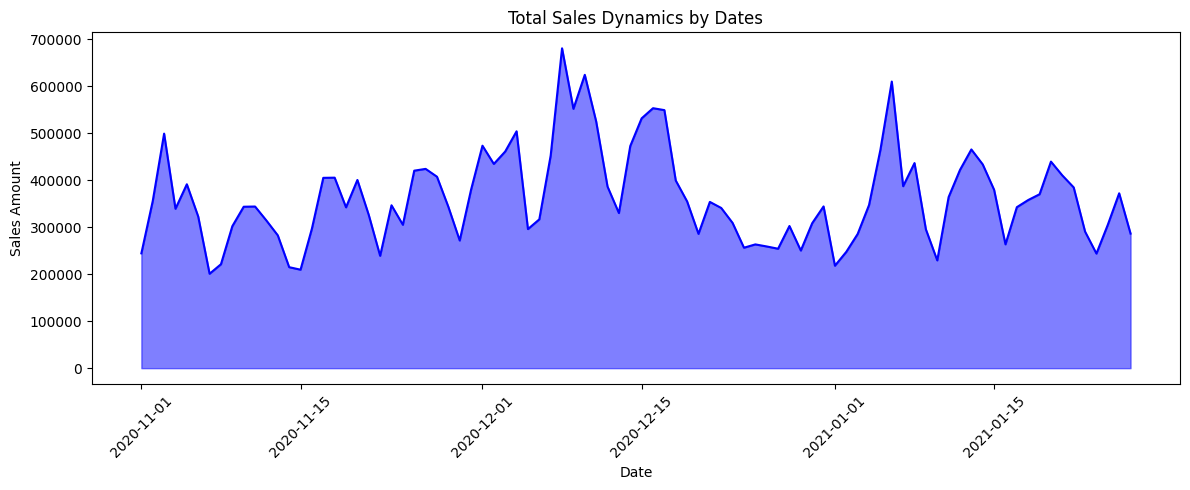

In [ ]:
daily_sales = df_sales.groupby('order_date')['price'].sum().reset_index()

plt.figure(figsize=(12, 5))
plt.fill_between(daily_sales['order_date'], daily_sales['price'], color='blue', alpha=0.5)
plt.plot(daily_sales['order_date'], daily_sales['price'], color='blue')  # контурна лінія
plt.title('Total Sales Dynamics by Dates')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

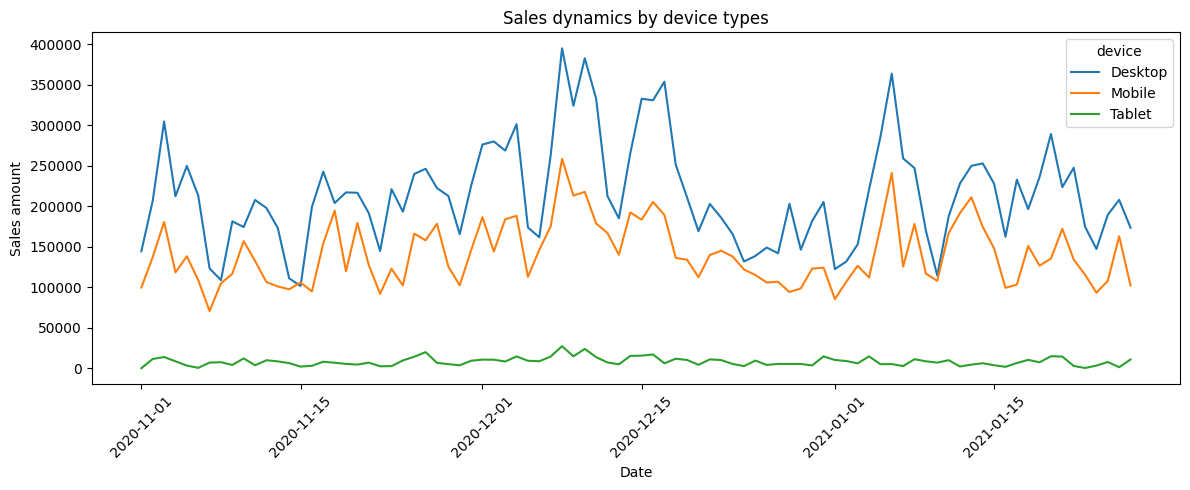

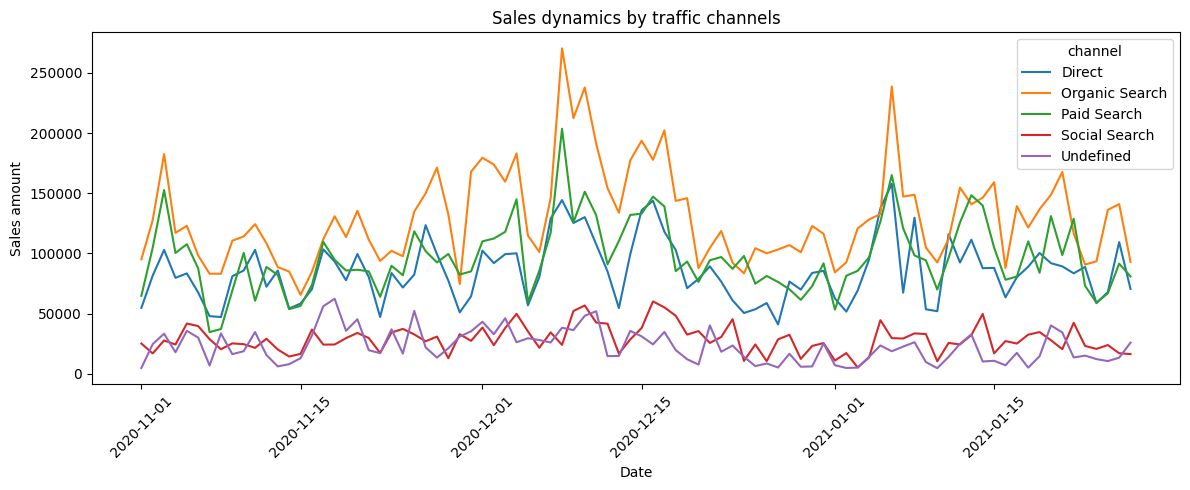

In [ ]:
# Sales dynamics by devices
daily_device_sales = df_sales.groupby(['order_date', 'device'])['price'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_device_sales, x='order_date', y='price', hue='device')
plt.title('Sales dynamics by device types')
plt.xlabel('Date')
plt.ylabel('Sales amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sales dynamics by channels
daily_channel_sales = df_sales.groupby(['order_date', 'channel'])['price'].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_channel_sales, x='order_date', y='price', hue='channel')
plt.title('Sales dynamics by traffic channels')
plt.xlabel('Date')
plt.ylabel('Sales amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Statistical analysis of the relationship

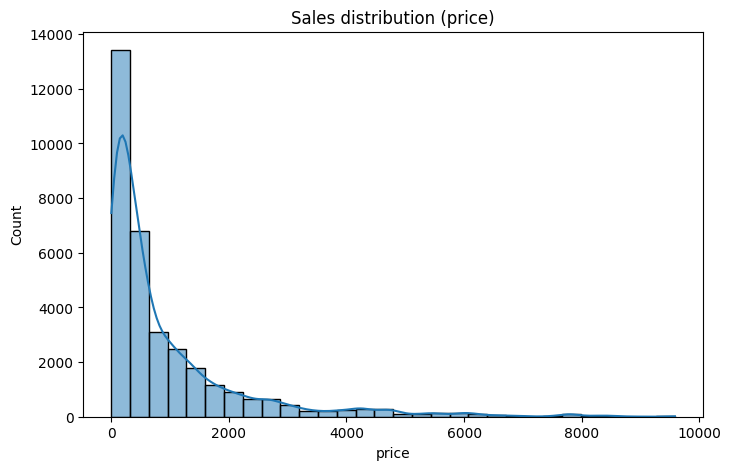

In [ ]:
# Sales distribution analysis

plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=30, kde=True)
plt.title("Sales distribution (price)")
plt.show()

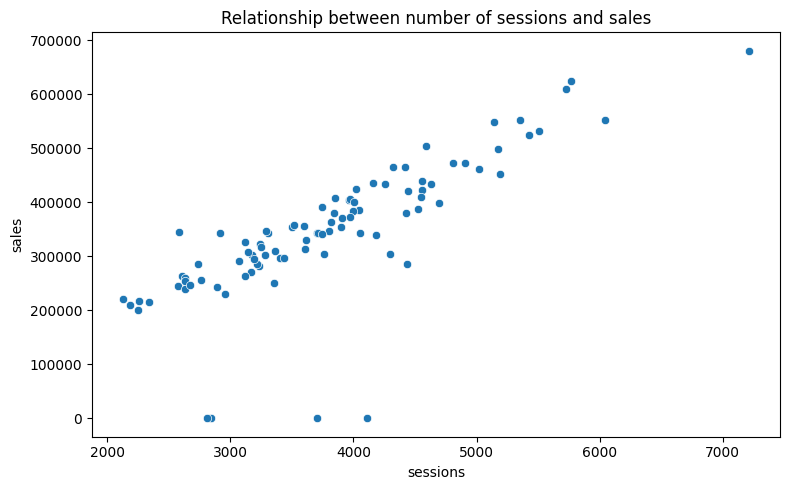

Spearman sessions vs sales: r=0.865, p=0.0000


In [ ]:
from scipy.stats import spearmanr

daily_metrics = df.groupby('order_date').agg(sessions=('ga_session_id', 'nunique'), sales=('price', 'sum')).reset_index()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=daily_metrics, x='sessions', y='sales')
plt.title('Relationship between number of sessions and sales')
plt.tight_layout()
plt.show()

# Correlation (Spearman, because data is not normal)
r, p = spearmanr(daily_metrics['sessions'], daily_metrics['sales'])
print(f"Spearman sessions vs sales: r={r:.3f}, p={p:.4f}")


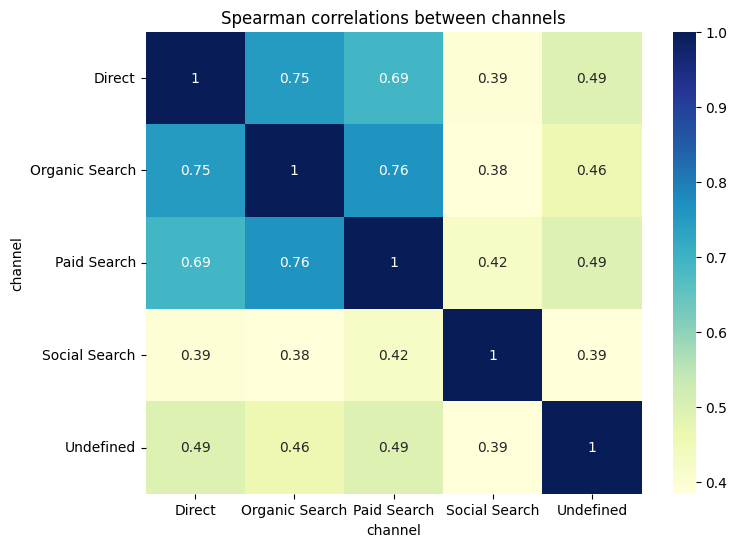

In [ ]:
channel_daily = df_sales.pivot_table(index='order_date', columns='channel', values='price', aggfunc='sum').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(channel_daily.corr(method='spearman'), annot=True, cmap='YlGnBu')
plt.title('Spearman correlations between channels')
plt.show()

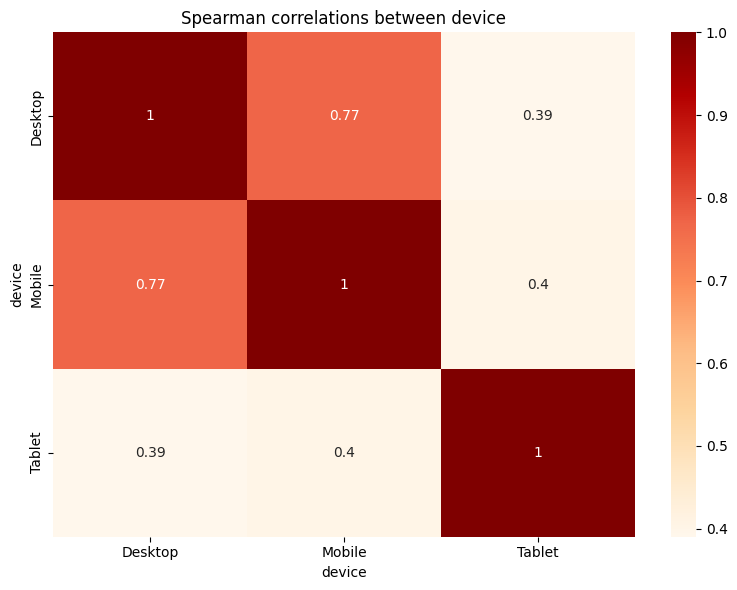

In [ ]:
device_daily = df_sales.pivot_table(index='order_date', columns='device', values='price', aggfunc='sum').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(device_daily.corr(method='spearman'), annot=True, cmap='OrRd')
plt.title('Spearman correlations between device')
plt.tight_layout()
plt.show()

## Statistical analysis of differences between groups

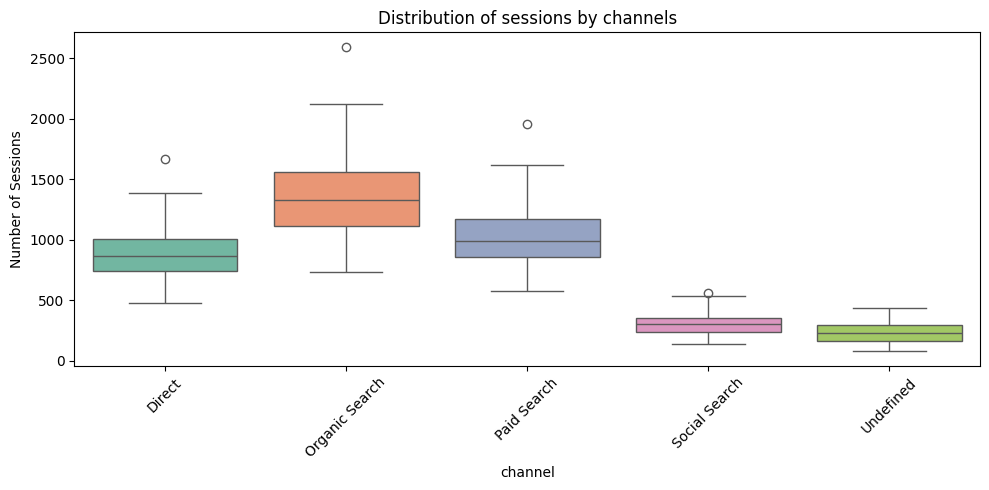

=== Shapiro-Wilk (normality) for each group ===
Direct         : W=0.970, p=0.034
Organic Search : W=0.964, p=0.012
Paid Search    : W=0.963, p=0.011
Social Search  : W=0.979, p=0.141
Undefined      : W=0.973, p=0.055

Levene (equality of variances): W=31.753, p=0.000

=== Kruskal–Wallis ===
Statistic=368.981, p-value=0.0000
p < 0.05 → there are statistically significant differences between channels


In [ ]:
from scipy.stats import shapiro, levene, f_oneway, kruskal

# Aggregation: count unique sessions per day for each channel
sessions = df.groupby(['channel', 'order_date'])['ga_session_id'].nunique().reset_index(name='sessions')

# Visualization of session distribution by channels
plt.figure(figsize=(10, 5))
sns.boxplot(x='channel', y='sessions', data=sessions, hue='channel', palette='Set2')
plt.xticks(rotation=45)
plt.title('Distribution of sessions by channels')
plt.ylabel('Number of Sessions')
plt.tight_layout()
plt.show()

# Test normality and homogeneity of variances
channels = sessions['channel'].unique()
grouped = [sessions[sessions['channel'] == ch]['sessions'] for ch in channels]

print("=== Shapiro-Wilk (normality) for each group ===")
for ch, grp in zip(channels, grouped):
    stat, p = shapiro(grp)
    print(f"{ch:15s}: W={stat:.3f}, p={p:.3f}")

stat_levene, p_levene = levene(*grouped)
print(f"\nLevene (equality of variances): W={stat_levene:.3f}, p={p_levene:.3f}")

# Choose statistical test
# If ALL groups are normal and variances are equal → ANOVA, else → Kruskal–Wallis
if all(shapiro(grp).pvalue > 0.05 for grp in grouped) and p_levene > 0.05:
    test_name = 'ANOVA'
    stat_test, p_test = f_oneway(*grouped)
else:
    test_name = 'Kruskal–Wallis'
    stat_test, p_test = kruskal(*grouped)

print(f"\n=== {test_name} ===")
print(f"Statistic={stat_test:.3f}, p-value={p_test:.4f}")

# Conclusion
alpha = 0.05
if p_test < alpha:
    print(f"p < {alpha} → there are statistically significant differences between channels")
else:
    print(f"p ≥ {alpha} → no statistically significant differences between channels were found")


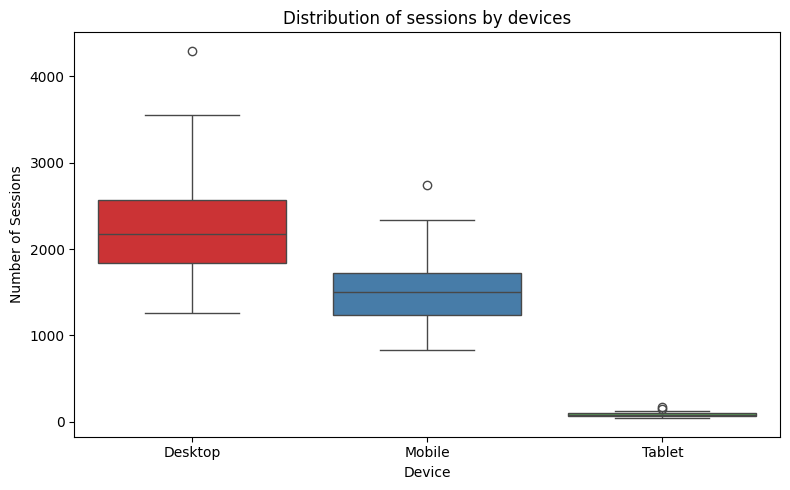

=== Shapiro-Wilk (normality) for each group ===
Desktop   : W=0.963, p=0.011
Mobile    : W=0.976, p=0.088
Tablet    : W=0.973, p=0.055

Levene (equality of variances): W=69.345, p=0.000

=== Kruskal–Wallis ===
Statistic=216.683, p-value=0.0000
p < 0.05 → there are statistically significant differences between devices


In [ ]:
# Aggregation: count unique sessions per day for each device
sessions_dev = df.groupby(['device', 'order_date'])['ga_session_id'].nunique().reset_index(name='sessions')

# Visualization of session distribution by devices
plt.figure(figsize=(8, 5))
sns.boxplot(x='device', y='sessions', data=sessions_dev, hue='device', palette='Set1')
plt.xticks(rotation=0)
plt.title('Distribution of sessions by devices')
plt.ylabel('Number of Sessions')
plt.xlabel('Device')
plt.tight_layout()
plt.show()

# Test normality and homogeneity of variances
devices = sessions_dev['device'].unique()
groups = [sessions_dev[sessions_dev['device'] == d]['sessions'] for d in devices]

print("=== Shapiro-Wilk (normality) for each group ===")
for d, grp in zip(devices, groups):
    stat, p = shapiro(grp)
    print(f"{d:10s}: W={stat:.3f}, p={p:.3f}")

stat_levene, p_levene = levene(*groups)
print(f"\nLevene (equality of variances): W={stat_levene:.3f}, p={p_levene:.3f}")

# Choose statistical test
# If ALL groups are normal and variances are equal → ANOVA, else → Kruskal–Wallis
if all(shapiro(grp).pvalue > 0.05 for grp in groups) and p_levene > 0.05:
    test_name = 'ANOVA'
    stat_test, p_test = f_oneway(*groups)
else:
    test_name = 'Kruskal–Wallis'
    stat_test, p_test = kruskal(*groups)

print(f"\n=== {test_name} ===")
print(f"Statistic={stat_test:.3f}, p-value={p_test:.4f}")

# Conclusion
alpha = 0.05
if p_test < alpha:
    print(f"p < {alpha} → there are statistically significant differences between devices")
else:
    print(f"p ≥ {alpha} → no statistically significant differences between devices were found")


# Dashboard in Tableau Public

In [ ]:
#Creating CSV for Tableau Public
df.to_csv('df.csv', index=False)
df_sales.to_csv('df_sales.csv', index=False)

from google.colab import files
files.download('df.csv')
files.download('df_sales.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[Dashboard in Tableau Public](https://public.tableau.com/app/profile/yelyzaveta.tkachenko/viz/Analysisbydeviceandchannel/Analysisbydeviceandchannel?publish=yes)

# Conclusion

Desktop users make 58.5% of sessions and generate 43% of revenue (18.9M), while mobile accounts for 39.3% of sessions and 28% of revenue (12.4M). Tablets have less than 3% of sessions and only 2% of sales. By traffic channels, Organic Search (35.6% of sessions; 11.4M) and Paid Search (27.0% of sessions; 8.5M) lead the way, together providing over 60% of sessions and more than 50% of revenue.

Geographically, the main markets are Americas (17.7M), Asia (7.6M) and Europe (5.9M), with the USA generating almost half of revenue (13.9M), followed by India (2.8M) and Canada (2.4M).

The Top-3 product categories by revenue are sofas & armchairs (8.4M), chairs (6.1M) and beds (4.9M). Desktop buyers dominate in all categories, while mobile shows relatively stronger results in bookcases and chairs.

Sales dynamics show several peaks: desktop is always higher than mobile and tablet, while among channels, Organic Search is the leader and sometimes Paid Search giving way to Direct.

There is a positive linear correlation between daily sales and sessions; the strongest relationships are: Organic Search ↔ Paid Search (0.76), Organic Search ↔ Direct (0.75), Paid Search ↔ Direct (0.69), and among devices, desktop ↔ mobile (0.77).

The Kruskal–Wallis test confirmed statistically significant differences between channels and devices (p < 0.0000),

Recommendations:

*   Redirect part of the budget to Organic Search and Paid Search, which generate
over 60% of traffic and 50% of revenue.
*   Investigate the Undefined channel for more accurate attribution
*   Focus localized campaigns on key markets (USA, India, Canada).
*   Strengthen promotion of top categories (sofas, chairs, beds).